## PROJECT OVERVIEW

This project implements and compares several approaches for cell counting in microscopy images, using both regression-based CNNs and fully convolutional architectures that learn density maps. The goal is to estimate the number of fluorescent cell nuclei in synthetic images containing hundreds of small circular objects.

The project progresses through three modeling families:

* Baseline CNN regressor
    * A small convolutional network that extracts global features and predicts the count directly as a single scalar.

* Feature-rich CNN (CellCountCNNRegressor)
    * A deeper CNN that uses more convolutional blocks and larger receptive field, improving its ability to capture crowded regions.

* UNet-based density estimation model
    * A fully convolutional network that outputs a pixel-wise density map whose integral approximates the total cell count. This approach is standard in modern crowd-counting and microscopy papers.

In [2]:
# !pip install --upgrade pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install numpy pillow psutil pandas
# !pip install opencv-python
# !pip install matplotlib seaborn
# !pip install optuna


In [3]:
import os
import cv2
from scipy.ndimage import label, center_of_mass
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import time
import copy
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
import random
import pdb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os
import psutil
import torch
import gc

torch.set_num_threads(2)

def clear_memory(): #when memory issues
    gc.collect()
    torch.cuda.empty_cache()
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and not obj.is_cuda:
                del obj
        except:
            pass
    gc.collect()
    torch.cuda.empty_cache()

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

The dataset consists of paired images and binary label masks. Masks are converted into ground-truth density maps using Gaussian filtering, enabling the FCN/UNet models to learn spatial structure rather than only a scalar target.

In [82]:
MAX_COUNT = 256 * 256  
class CustomDataset(Dataset):
    def __init__(self, image_set='train'):
        self.data_path_img = f'counting_cells_data/{image_set}_images/'
        self.data_path_labels = f'counting_cells_data/{image_set}_labels/'
        self.image_paths = sorted([os.path.join(self.data_path_img, f)
                          for f in os.listdir(self.data_path_img)
                          if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

        self.label_paths = sorted([os.path.join(self.data_path_labels, f)
                         for f in os.listdir(self.data_path_labels)
                         if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))])


        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.target_transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        sample_img = Image.open(self.image_paths[idx]).convert('RGB')
        sample_target = Image.open(self.label_paths[idx])
        sample_img = self.transform(sample_img).float()
        sample_target = self.target_transform(sample_target).float()
        count = sample_target.sum().item()
        count=float(count)
        return sample_img, sample_target, count

In [83]:
batch_size = 16
image_val = CustomDataset(image_set='val')
image_train = CustomDataset(image_set='train')
dataset_sizes={'train': 0, 'val': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        prefetch_factor=2,
        persistent_workers=True
    ),
    'val': torch.utils.data.DataLoader(
        image_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        prefetch_factor=2,
        persistent_workers=True
    )
}
print(dataset_sizes)

{'train': 180, 'val': 20}


In [84]:
def show_img_pair(lr, hr, count=0, gen=None):
    lr_img = to_pil_image(lr)
    hr_img = to_pil_image(hr)

    images = [lr_img, hr_img]
    titles = ['Original', 'Target']

    if gen is not None:
        gen_img = to_pil_image(gen)
        images.append(gen_img)
        titles.append('Generated Res')

    num_images = len(images)
    plt.figure(figsize=(4 * num_images, 4))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(f"Image Count: {count}", fontsize=16)

    plt.tight_layout()
    plt.show()


### Visualization of the images

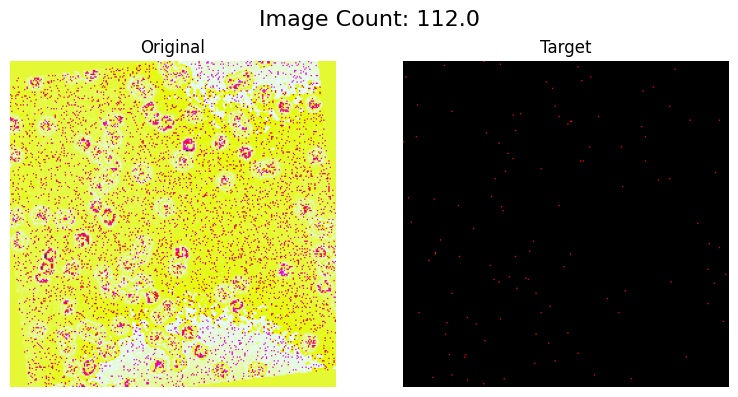

In [85]:
original, target, count = next(iter(dataloaders['train']))
n = random.choice(range(batch_size))
show_img_pair(original[n], target[n], count[n])

### Baseline CNN regressor

The Baseline CNN is a minimal convolutional model that treats cell counting as a pure regression problem:
* Several blocks of convolution → nonlinearity → pooling extract global features from the image.

The spatial features are reduced using global pooling and passed into a fully connected layer that outputs a single scalar – the predicted count.

Key characteristics:

* The model focuses on learning a direct mapping from overall image appearance to total cell count.
* It does not attempt to reconstruct spatial information or produce per-pixel predictions.

That's a start

In [86]:
class BaselineCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(BaselineCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze()


In [ ]:
def train_one_model(
    model,
    dataloaders,
    dataset_sizes,
    device,
    lr=1e-3,
    weight_decay=1e-6,
    num_epochs=10
):

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()

    history_mae = {"train": [], "val": []}

    best_mae = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_mae = 0.0

            for inputs, masks, true_counts in dataloaders[phase]:
                inputs = inputs.to(device).float()
                masks = masks.to(device).float()
                true_counts = true_counts.to(device).float()


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    pred_counts = outputs
                    loss = criterion_mse(pred_counts, true_counts) + \
                               criterion_mae(pred_counts, true_counts)


                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_mae += torch.sum(torch.abs(pred_counts - true_counts))

            epoch_mae = (running_mae / dataset_sizes[phase]).item()
            history_mae[phase].append(epoch_mae)

            print(f"{phase} MAE: {epoch_mae:.4f}")

            if phase == "val" and epoch_mae < best_mae:
                best_mae = epoch_mae
                best_model_state = model.state_dict()

    print(f"\nBest validation MAE: {best_mae:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history_mae



In [88]:
def plot_mae_curve(history):
    plt.figure(figsize=(8,5))
    plt.plot(history["train"], label="Train MAE")
    plt.plot(history["val"], label="Val MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("MAE over epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


In [89]:
def plot_pred_vs_true(model, dataloader, device):
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for inputs, _, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze().cpu().tolist()
            preds += outputs if isinstance(outputs, list) else [outputs]
            trues += labels.cpu().tolist()

    plt.figure(figsize=(6,6))
    sns.scatterplot(x=trues, y=preds, alpha=0.6)
    sns.lineplot(x=trues, y=trues, color="red")  # perfect line
    plt.xlabel("True Count")
    plt.ylabel("Predicted Count")
    plt.title("Predicted vs True Cell Counts")
    plt.grid(True)
    plt.show()



Epoch 1/20
----------------------------------------
train MAE: 86.9291
val MAE: 60.4125

Epoch 2/20
----------------------------------------
train MAE: 46.2049
val MAE: 43.4824

Epoch 3/20
----------------------------------------
train MAE: 42.7723
val MAE: 44.5245

Epoch 4/20
----------------------------------------
train MAE: 43.2882
val MAE: 43.0845

Epoch 5/20
----------------------------------------
train MAE: 36.7964
val MAE: 50.9515

Epoch 6/20
----------------------------------------
train MAE: 47.2372
val MAE: 47.0094

Epoch 7/20
----------------------------------------
train MAE: 38.3534
val MAE: 37.7055

Epoch 8/20
----------------------------------------
train MAE: 36.7869
val MAE: 46.7832

Epoch 9/20
----------------------------------------
train MAE: 37.7125
val MAE: 41.1080

Epoch 10/20
----------------------------------------
train MAE: 32.7447
val MAE: 37.5513

Epoch 11/20
----------------------------------------
train MAE: 33.3898
val MAE: 48.4226

Epoch 12/20
------

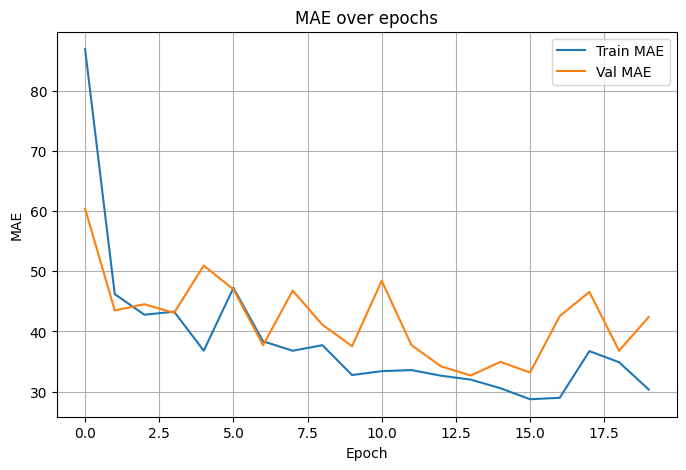

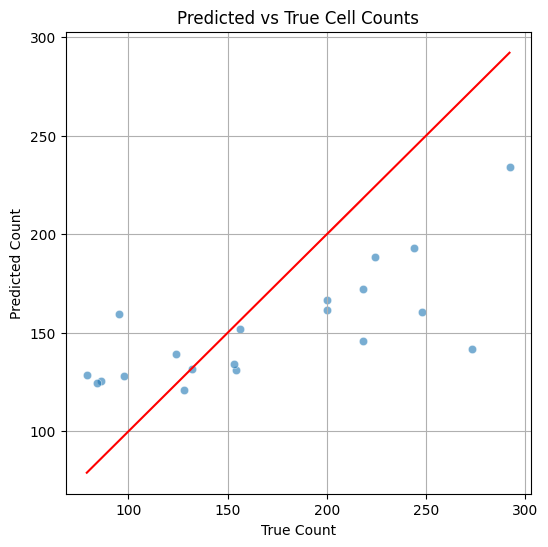

In [90]:
baseline = BaselineCNN()

trained_baseline, baseline_history = train_one_model(
    model=baseline,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    lr=1e-3,
    weight_decay=1e-6,
    num_epochs=20
)

plot_mae_curve(baseline_history)
plot_pred_vs_true(trained_baseline, dataloaders["val"], device)


### Baseline conclusion
The model successfully learns a rough mapping from image appearance to total count. Its predictions vary significantly and struggle with crowded regions.
Without spatial supervision, it cannot detect or reason about overlapping or dense clusters.

## CellCountCNNRegressor

This model increases capacity and depth to better capture complex patterns in the images:
* More convolutional blocks with BatchNorm improve feature stability.
* Successive max-pooling operations reduce spatial dimensions, allowing deeper receptive fields.
* AdaptiveAvgPool2d reduces the final feature map to a single descriptor vector.
* A learned scaling factor helps stabilize regression magnitudes.

We want to try it cause it should be  able to learn richer hierarchical representations than the baseline model and handle crowded regions due to deeper layers and broader receptive field.
it still predicts a single global scalar, so it does not learn where objects are — only how many.

In [91]:
class CellCountCNNRegressor(nn.Module):
    def __init__(self, input_channels=3):
        super(CellCountCNNRegressor, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.layer7 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Softplus()
        )
        self.scaling_factor = nn.Parameter(torch.tensor([450.0]))

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = x * self.scaling_factor
        return x.squeeze()


Epoch 1/20
----------------------------------------
train MAE: 66.1158
val MAE: 102.1588

Epoch 2/20
----------------------------------------
train MAE: 27.4428
val MAE: 77.7651

Epoch 3/20
----------------------------------------
train MAE: 22.5230
val MAE: 46.6988

Epoch 4/20
----------------------------------------
train MAE: 23.7864
val MAE: 54.5691

Epoch 5/20
----------------------------------------
train MAE: 19.0550
val MAE: 19.3945

Epoch 6/20
----------------------------------------
train MAE: 19.9041
val MAE: 18.7973

Epoch 7/20
----------------------------------------
train MAE: 22.4792
val MAE: 12.6794

Epoch 8/20
----------------------------------------
train MAE: 19.3979
val MAE: 21.3461

Epoch 9/20
----------------------------------------
train MAE: 19.4057
val MAE: 10.2359

Epoch 10/20
----------------------------------------
train MAE: 17.7098
val MAE: 32.9798

Epoch 11/20
----------------------------------------
train MAE: 16.2895
val MAE: 10.3246

Epoch 12/20
-----

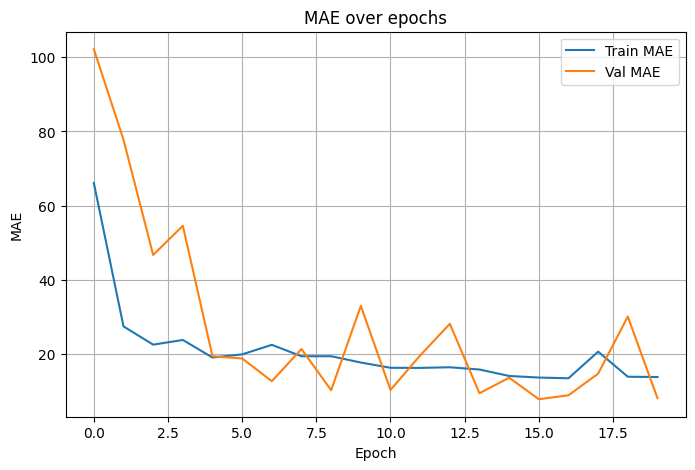

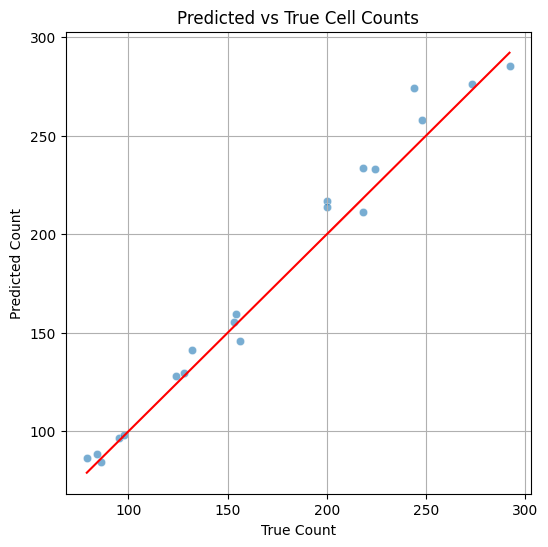

In [92]:
cnn_regressor = CellCountCNNRegressor()

trained_cnn_regressor, cnn_regressor_history = train_one_model(
    model=cnn_regressor,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    lr=1e-3,
    weight_decay=1e-6,
    num_epochs=20
)

plot_mae_curve(cnn_regressor_history)
plot_pred_vs_true(trained_cnn_regressor, dataloaders["val"], device)


## CellCount Conlusion:

It improves accuracy compared to the baseline (MAE ~32 -> ~8). Expanded receptive field and better normalization help extract crowd-density information indirectly. But still limited by the regression-only formulation—performance plateaus because the model cannot use pixel-level structure.

In [193]:
class DotDensityDataset(Dataset):
    def __init__(self, image_set='train', sigma=4):
        self.img_dir = f"counting_cells_data/{image_set}_images/"
        self.lbl_dir = f"counting_cells_data/{image_set}_labels/"
        self.sigma = sigma
        self.img_paths = sorted([
            os.path.join(self.img_dir, x)
            for x in os.listdir(self.img_dir)
            if x.lower().endswith((".png", ".jpg", ".jpeg"))
        ])
        self.lbl_paths = sorted([
            os.path.join(self.lbl_dir, x)
            for x in os.listdir(self.lbl_dir)
            if x.lower().endswith((".png", ".jpg", ".jpeg"))
        ])
        self.img_tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_pil = Image.open(self.img_paths[idx]).convert("RGB")
        img = self.img_tf(img_pil)
        
        lbl_np = np.array(Image.open(self.lbl_paths[idx]).convert("RGB"))
        H, W, _ = lbl_np.shape
        
        red = lbl_np[:, :, 0]
        green = lbl_np[:, :, 1]
        blue = lbl_np[:, :, 2]
        dot_mask = (red > 200) & (green < 50) & (blue < 50)
        ys, xs = np.where(dot_mask)
        count = len(xs)  
        density = np.zeros((H, W), dtype=np.float32)
        for x, y in zip(xs, ys):
            density[y, x] = 1.0
        
        density = cv2.GaussianBlur(density, (21, 21), self.sigma)
        
        s = density.sum()
        if s > 0:
            density = density * (count / s)
        
        density = torch.from_numpy(density).unsqueeze(0)
        return img, density.float(), torch.tensor(count, dtype=torch.float32)


## UNet for Density Maps
Both previous models approached cell counting as a regression problem: the network extracted global features from the image and tried to predict a single number. This works to some degree, but it ignores where the cells are and how densely they are packed. Lets shif the approach and eather than predicting the final count, reconstruct a full spatial density map of the cells using UNet.The UNet is a fully convolutional encoder–decoder architecture that outputs a pixel-wise density map instead of a single number. It combines deep features that capture global context (via downsampling), and fine-grained spatial information preserved through skip connections (via upsampling).
(we will have to update dataloaders and training loop for that)

In [ ]:
class UNet(nn.Module):
    """
    U-Net with BatchNorm and ReLU output
    """
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(512, 1024)
        
        # Decode
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.out = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.ReLU() 
        )
    
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        
        b = self.bottleneck(p4)
        
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.out(d1)


In [ ]:
def train_density_unet(
    model,
    dataloaders,
    dataset_sizes,
    device,
    lr=1e-4,
    num_epochs=30,
    patience=10
):
    """
    """
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    loss_density = nn.MSELoss()
    loss_count = nn.L1Loss()
    
    best_mae = float('inf')
    hist = {"train": [], "val": []}
    best_state = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_mae = 0.0
            running_loss = 0.0
            
            for imgs, dens_tgt, true_count in dataloaders[phase]:
                imgs = imgs.to(device)
                dens_tgt = dens_tgt.to(device)
                true_count = true_count.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    dens_pred = model(imgs)
                    pred_count = dens_pred.sum(dim=[1, 2, 3])
                    

                    l_density = loss_density(dens_pred, dens_tgt)
                    l_count = loss_count(pred_count, true_count)
                    
                    loss = l_density + 0.1 * l_count
                    
                    if phase == "train":
                        loss.backward()
                        
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        
                        optimizer.step()
                
                batch_mae = (pred_count - true_count).abs().sum().item()
                running_mae += batch_mae
                running_loss += loss.item() * imgs.size(0)
            
            epoch_mae = running_mae / dataset_sizes[phase]
            hist[phase].append(epoch_mae)
            
            print(f"{phase} MAE: {epoch_mae:.3f}")
            
            if phase == "val":
                scheduler.step(epoch_mae)
                
                if epoch_mae < best_mae:
                    best_mae = epoch_mae
                    best_state = model.state_dict().copy()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s)")
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print(f"\nBest Validation MAE: {best_mae:.3f}")
    
    if best_state:
        model.load_state_dict(best_state)
    
    return model, hist


In [205]:
def plot_pred_vs_true(model, dataloader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, _, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).sum(dim=[1, 2, 3]).cpu().tolist()
            preds += outputs if isinstance(outputs, list) else [outputs]
            trues += labels.cpu().tolist()
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=trues, y=preds, alpha=0.6)
    max_val = max(max(trues), max(preds))
    sns.lineplot(x=[0, max_val], y=[0, max_val], color="red", label="Perfect prediction")
    plt.xlabel("True Count", fontsize=12)
    plt.ylabel("Predicted Count", fontsize=12)
    plt.title("Predicted vs True Cell Counts", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [211]:
def visualize_predictions(model, dataset, device, num_samples=4):
    """
    Visualize predicted density maps vs ground truth
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img, dens_true, count_true = dataset[idx]
        
        with torch.no_grad():
            img_batch = img.unsqueeze(0).to(device)
            dens_pred = model(img_batch).squeeze().cpu().numpy()
        
        dens_true = dens_true.squeeze().numpy()
        count_pred = dens_pred.sum()
        
        img_display = img.permute(1, 2, 0).numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)
        
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Input Image\nTrue Count: {count_true:.0f}")
        axes[i, 0].axis('off')
        
        im1 = axes[i, 1].imshow(dens_true, cmap='hot')
        axes[i, 1].set_title(f"True Density Map\nSum: {dens_true.sum():.1f}")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1])
        
        im2 = axes[i, 2].imshow(dens_pred, cmap='hot')
        axes[i, 2].set_title(f"Predicted Density Map\nSum: {count_pred:.1f}")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2])
    
    plt.tight_layout()
    plt.show()


In [ ]:
density_train = DotDensityDataset(image_set="train", sigma=4)
density_val = DotDensityDataset(image_set="val", sigma=4)


dataloaders_density = {
    "train": DataLoader(density_train, batch_size=4, shuffle=True, num_workers=0),
    "val": DataLoader(density_val, batch_size=4, shuffle=False, num_workers=0),
}

dataset_sizes_density = {
    "train": len(density_train),
    "val": len(density_val)
}



Epoch 1/50
train MAE: 663.631
val MAE: 167.753

Epoch 2/50
train MAE: 194.769
val MAE: 73.057

Epoch 3/50
train MAE: 66.189
val MAE: 36.294

Epoch 4/50
train MAE: 53.871
val MAE: 23.727

Epoch 5/50
train MAE: 44.531
val MAE: 48.414
No improvement for 1 epoch(s)

Epoch 6/50
train MAE: 31.495
val MAE: 19.601

Epoch 7/50
train MAE: 29.091
val MAE: 27.379
No improvement for 1 epoch(s)

Epoch 8/50
train MAE: 33.396
val MAE: 16.437

Epoch 9/50
train MAE: 25.167
val MAE: 20.685
No improvement for 1 epoch(s)

Epoch 10/50
train MAE: 27.821
val MAE: 33.745
No improvement for 2 epoch(s)

Epoch 11/50
train MAE: 30.483
val MAE: 22.333
No improvement for 3 epoch(s)

Epoch 12/50
train MAE: 23.024
val MAE: 38.676
No improvement for 4 epoch(s)

Epoch 13/50
train MAE: 21.752
val MAE: 63.403
No improvement for 5 epoch(s)

Epoch 14/50
train MAE: 23.051
val MAE: 11.623

Epoch 15/50
train MAE: 19.182
val MAE: 16.894
No improvement for 1 epoch(s)

Epoch 16/50
train MAE: 19.871
val MAE: 19.368
No improvement

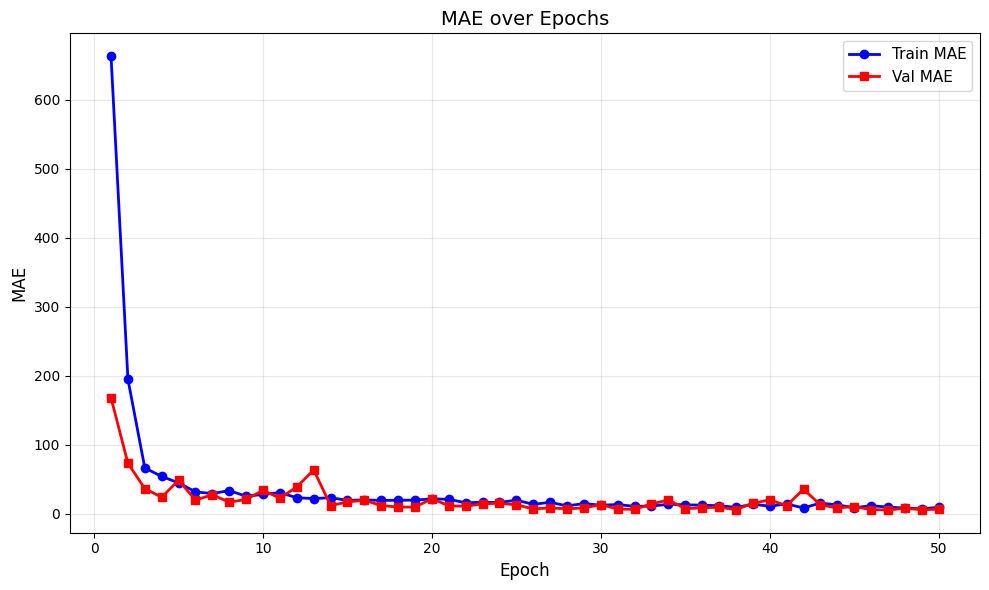

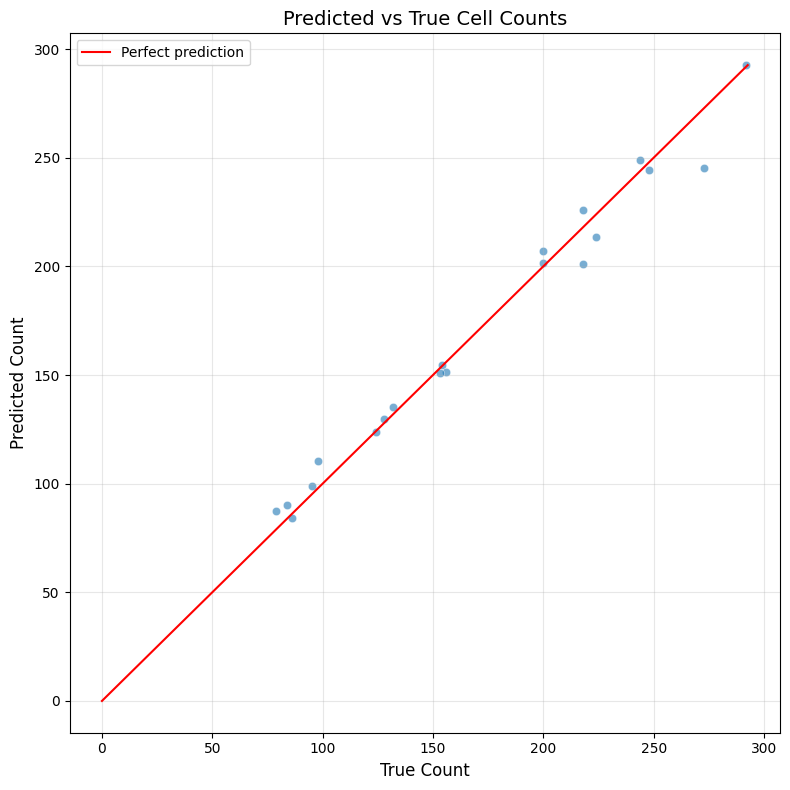

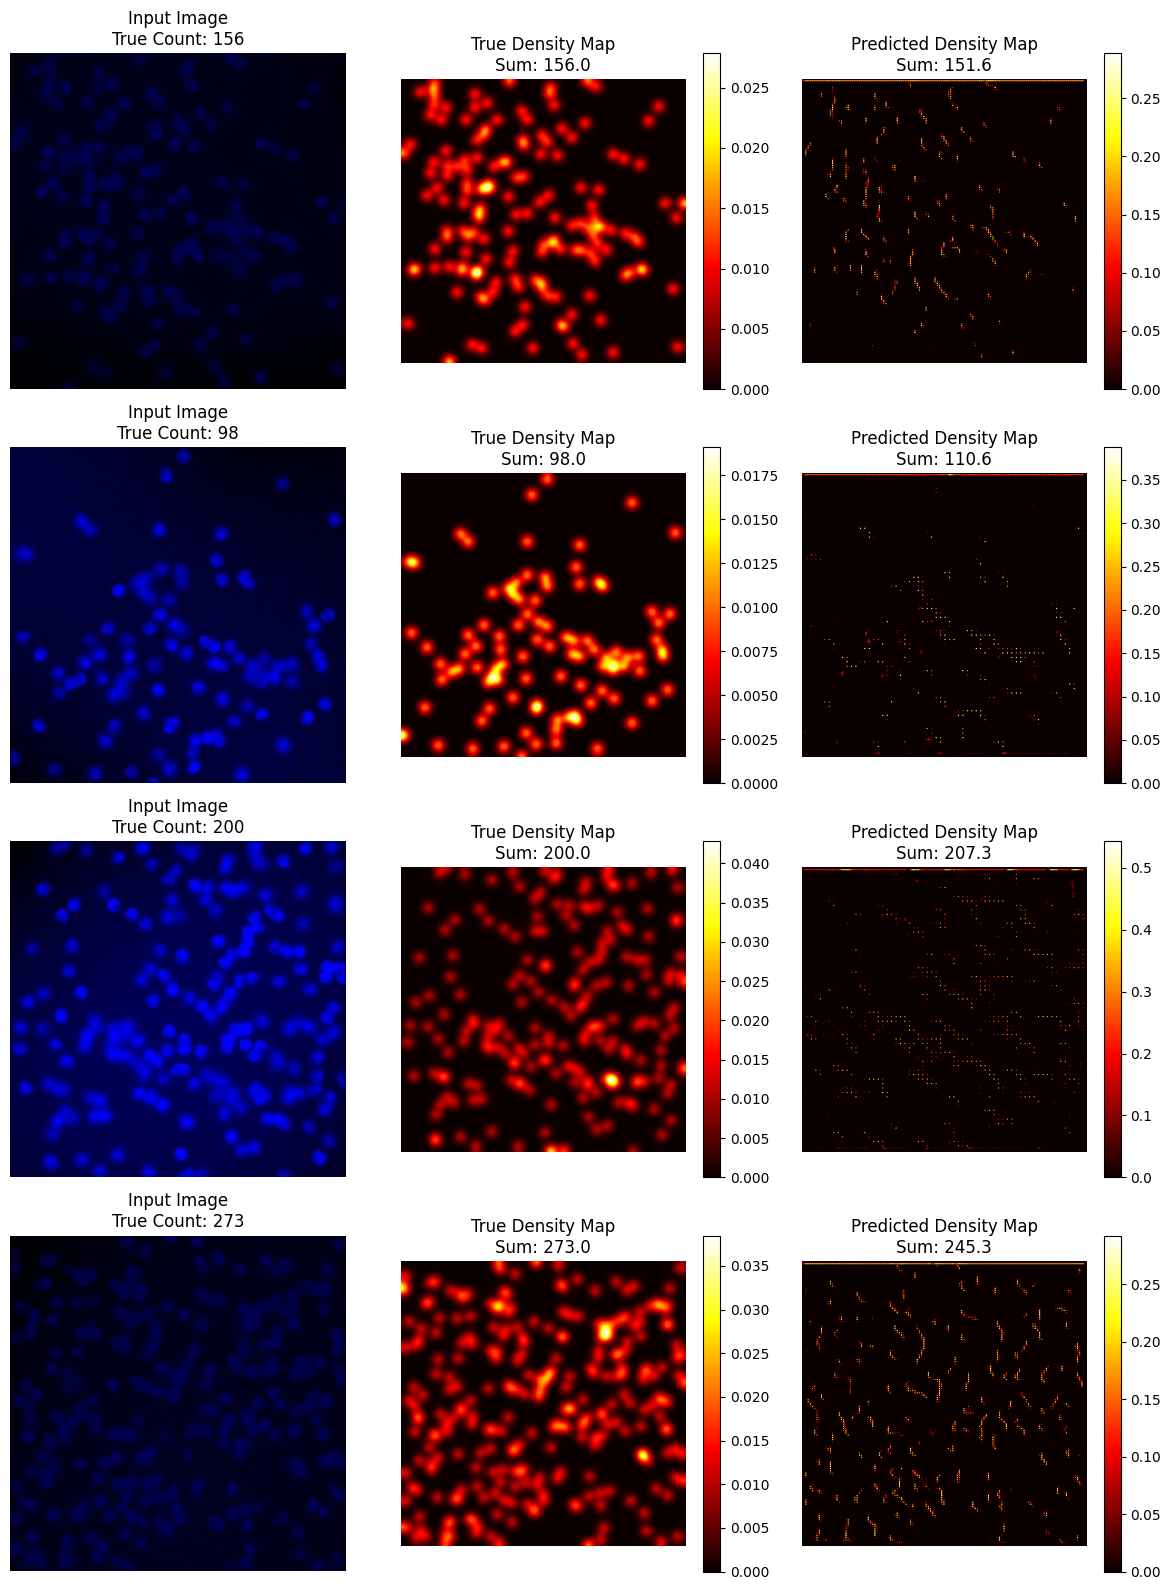

In [217]:
model = UNet(in_channels=3, out_channels=1)
trained_model, history = train_density_unet(
        model=model,
        dataloaders=dataloaders_density,
        dataset_sizes=dataset_sizes_density,
        device=device,
        lr=3e-4,
        num_epochs=50,
        patience=10
    )
    
plot_mae_curve(history)
plot_pred_vs_true(trained_model, dataloaders_density["val"], device)
visualize_predictions(trained_model, density_val, device, num_samples=4)
    


## Unet conclusion
Even though its not a very big difference from the CellCounter, the Unet is the best performing model. It also learns the spatial arrangement of points, producing both accurate counts and meaningful density maps, which is very useful in general. It is also considerably more stable across different densities and image variations.

## CONCLUSION

This project demonstrates that cell counting accuracy strongly depends on how the model represents the task:
* Simple CNN regressors can learn coarse patterns but are fundamentally limited by the lack of spatial supervision.
*  Adding depth and normalization greatly improves regression performance, showing the importance of hierarchical features.
* Fully convolutional density-based models (UNet in this case) outperform regression methods because they learn where objects are, not only how many.

The UNet achieves the best results, produces interpretable density maps, and remains stable during training.

For practical microscopy or crowd-counting applications, density-based architectures are the most reliable approach, and this project replicates that pattern cleanly.